In [1]:
import csv
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Data Loading

In [2]:
import datasets

dataset = datasets.C100Dataset('dataset/data/cifar100_nl.csv', 'dataset/data/cifar100_nl_test.csv')
[trainData, trainLabels, testData, testLabels] = dataset.getDataset()

Test set shape: (9999, 32, 32, 3)
Test labels shape: (9999,)
Training set shape: (49999, 32, 32, 3)
Training labels shape: (49999,)


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torchvision.transforms as transforms

# Assuming trainData, trainLabels, valData, and valLabels are numpy arrays
trainData, valData, trainLabels, valLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=42)

# Calculate the mean
mean = np.mean(trainData, axis=(0, 1, 2))  # Compute mean along each channel

# Calculate the standard deviation
std = np.std(trainData, axis=(0, 1, 2))  # Compute standard deviation along each channel

print("Mean:", mean)
print("Standard Deviation:", std)

# Mean: [0.50764684 0.48674372 0.44104357]
# Standard Deviation: [0.26745035 0.25658456 0.27634654]
stats = ((0.50764684, 0.48674372, 0.44104357), (0.26745035, 0.25658456, 0.27634654))

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),    # Convert to tensor
    transforms.Normalize((0.50764684, 0.48674372, 0.44104357), (0.26745035, 0.25658456, 0.27634654))    # Normalize the data
])


Mean: [129.44994536 124.11964935 112.46610992]
Standard Deviation: [68.19983963 65.42906359 70.46836834]


In [4]:

import PIL.Image

trainData = torch.stack([transform((image)) for image in trainData])
valData = torch.stack([transform((image)) for image in valData])
testData = torch.stack([transform((image)) for image in testData])


# Convert numpy arrays to torch tensors
trainLabels = torch.from_numpy(trainLabels)
valLabels = torch.from_numpy(valLabels)
testLabels = torch.from_numpy(testLabels)

# Convert to float
trainData = trainData.to(torch.float32)
trainLabels = trainLabels.to(torch.int64)
valData = valData.to(torch.float32)
valLabels = valLabels.to(torch.int64)
testData = testData.to(torch.float32)
testLabels = testLabels.to(torch.int64)

# Create TensorDatasets
trainDataset = TensorDataset(trainData, trainLabels)
valDataset = TensorDataset(valData, valLabels)
testDataset = TensorDataset(testData, testLabels)

# Create DataLoaders
trainLoader = DataLoader(trainDataset, batch_size=128, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=128, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=128, shuffle=False)

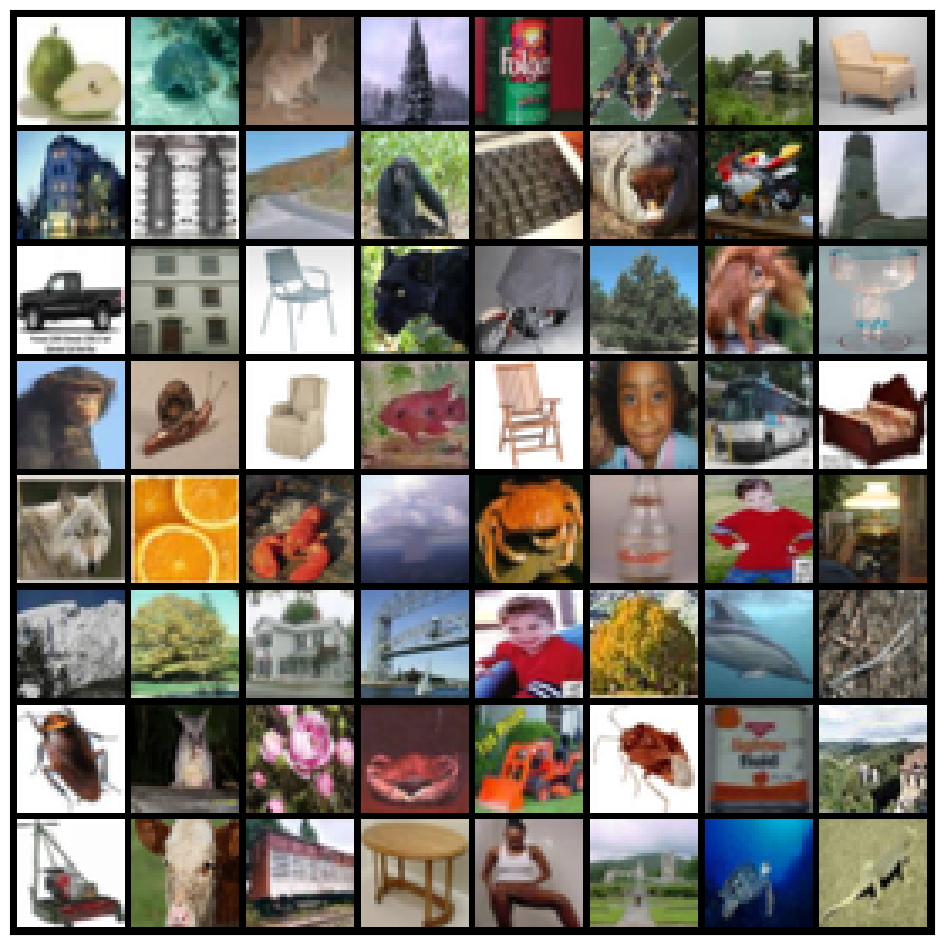

In [5]:
# Show image for fun
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(trainLoader)


Model Architecture and Training

In [6]:
import os
import pickle
import numpy as np
from itertools import chain
from model import CNN
import model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from absl import logging
from utils import EarlyStopping

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def co_teaching_loss(model1_loss, model2_loss, rt):
    _, model1_sm_idx = torch.topk(model1_loss, k=int(int(model1_loss.size(0)) * rt), largest=False)
    _, model2_sm_idx = torch.topk(model2_loss, k=int(int(model2_loss.size(0)) * rt), largest=False)

    # Co-teaching
    model1_loss_filter = torch.zeros((model1_loss.size(0))).cuda()
    model1_loss_filter[model2_sm_idx] = 1.0
    model1_loss = (model1_loss_filter * model1_loss).sum()

    model2_loss_filter = torch.zeros((model2_loss.size(0))).cuda()
    model2_loss_filter[model1_sm_idx] = 1.0
    model2_loss = (model2_loss_filter * model2_loss).sum()

    return model1_loss, model2_loss


def train_step(data_loader, gpu: bool, model_list: list, optimizer, criterion, rt, warmups):
    global_step = 0
    avg_accuracy = 0.
    avg_loss = 0.

    model1, model2 = model_list
    model1 = model1.train()
    model2 = model2.train()
    for x, y in data_loader:
        # Forward and Backward propagation
        x, y = x.to(device), y.to(device)

        out1 = model1(x)
        out2 = model2(x)

        model1_loss = criterion(out1, y)
        model2_loss = criterion(out2, y)
        model1_loss, model2_loss = co_teaching_loss(model1_loss=model1_loss, model2_loss=model2_loss, rt=rt)

        # loss exchange
        optimizer.zero_grad()
        model1_loss.backward()
        torch.nn.utils.clip_grad_norm_(model1.parameters(), 5.0)
        optimizer.step()

        optimizer.zero_grad()
        model2_loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 5.0)
        optimizer.step()

        avg_loss += (model1_loss.item() + model2_loss.item())

        # Compute accuracy
        acc = torch.eq(torch.argmax(out1, 1), y).float()
        avg_accuracy += acc.mean()
        global_step += 1

    return avg_accuracy / global_step, avg_loss / global_step, [model1, model2]



def test_step(data_loader, gpu: bool, model):
    model = model.eval()
    global_step = 0
    avg_accuracy = 0.
    predicted_labels = []

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = torch.max(logits, 1)
        acc = torch.eq(torch.argmax(logits, 1), y)
        acc = acc.cpu().numpy()
        acc = np.mean(acc)
        avg_accuracy += acc
        global_step += 1
        predicted_labels.extend(preds.cpu().numpy())

    return avg_accuracy / global_step, predicted_labels


def valid_step(data_loader, gpu: bool, model):
    model = model.eval()
    global_step = 0
    avg_accuracy = 0.

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        acc = torch.eq(torch.argmax(logits, 1), y)
        acc = acc.cpu().numpy()
        acc = np.mean(acc)
        avg_accuracy += acc
        global_step += 1
    return avg_accuracy / global_step


def update_reduce_step(cur_step1, num_gradual, tau):
    return 1.0 - tau * min(cur_step1 / num_gradual, 1)


def train(lr, tau, num_gradual, warmups, gpu = True, epochs = 10):
    model1 = model.resnet56()
    model2 = model.resnet56()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model1 = nn.DataParallel(model1)
        model2 = nn.DataParallel(model2)

    model1.to(device)
    model2.to(device)

    # learning history
    train_acc_list = []
    test_acc_list = []

    #early_stopping = EarlyStopping(patience=FLAGS.stop_patience, verbose=False)
    criterion = nn.CrossEntropyLoss(reduce=False)
    optimizer = optim.Adam(chain(model1.parameters(), model2.parameters()), lr)
    for e in range(epochs):
        # update reduce step
        curstep1 = e
        rt = update_reduce_step(curstep1, num_gradual, tau)

        # training step
        train_accuracy, avg_loss, model_list = train_step(data_loader=trainLoader,
                                                          gpu=gpu,
                                                          model_list=[model1, model2],
                                                          optimizer=optimizer,
                                                          criterion=criterion,
                                                          rt=rt,
                                                          warmups=warmups)
        model1, model2 = model_list

        if warmups > 0:
            warmups = warmups - 1

        # testing/valid step
        test_accuracy, predicted_labels = test_step(data_loader=testLoader,
                                  gpu=gpu,
                                  model=model1)

        dev_accuracy = valid_step(data_loader=valLoader,
                                  gpu=gpu,
                                  model=model1)

        train_accuracy = train_accuracy.cpu().data.numpy()
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)

        logging.info(
            '{} epoch, Train Loss {}, Train accuracy {}, Dev accuracy {}, Test accuracy {}, Reduce rate {}'.format(e + 1,
                                                                                                                avg_loss,
                                                                                                                train_accuracy,
                                                                                                                dev_accuracy,
                                                                                                                test_accuracy,
                                                                                                                rt))

        # early_stopping(-dev_accuracy, model1, test_acc=test_accuracy)
        # if early_stopping.early_stop:
        #     logging.info('Training stopped! Best accuracy = {}'.format(max(early_stopping.acc_list)))
        #     break

    # learning curve plot
    return train_acc_list, test_acc_list, epochs, predicted_labels

Run and Evaluation

In [7]:
# Set parameters



train_acc_list, test_acc_list, epochs, predicted_labels = train(lr=0.001, tau=0.3, warmups=50, num_gradual=30, gpu=True, epochs=30)
#Set warmups to 0 to only use prediction co-teaching 

print(train_acc_list)


xrange = [(i + 1) for i in range(epochs)]
plt.plot(xrange, train_acc_list, 'b', label='Training accuracy')
plt.plot(xrange, test_acc_list, 'r', label='Test accuracy')
plt.legend()
plt.title('Learning Curve')
plt.savefig('l_curve.png')

c:\Users\aaron\miniconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
xrange = [(i + 1) for i in range(epochs)]
plt.plot(xrange, train_acc_list, 'b', label='training accuracy')
plt.plot(xrange, test_acc_list, 'r', label='test accuracy')
plt.legend()
plt.title('Learning curve')
plt.savefig('l_curve.png')